## Example Notebook of Creating and then optimising a phased array

---

This notebook gives simple examples of how one could use the module: `NonUniform_2D_PhasedArrayFunctions`. 

**Steps**:

1. You will create a randomised array with N antenna elements
2. Choose an objective function to score the array designs
3. Choose a number of iterations
4. Make sure to have the desired constraints and settings programed in the NonUniform_2D_PhasedArrayFunctions.py file
5. You can end the optimisation anytime and the best array will be saved as a csv file


**Notes:**

Make sure you have the file `NonUniform_2D_PhasedArrayFunctions.py` in the same directory as this notebook or you will not be able to load it in.

#### **Imports:**

In [1]:
import importlib
import pandas as pd
import NonUniform_2D_PhasedArrayFunctions as PAA
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sns

In [5]:
# Run this if you edit NonUniform_2D_PhasedArrayFunctions.py and wish to reload it into the notebook without restarting the kernal
importlib.reload(PAA)
import NonUniform_2D_PhasedArrayFunctions as PAA

**Building and then optimising an antenna array**

Objective Functions:

1. `score_array_angles_and_separations`: Uniformity of the distribution of both the baseline angles and the magnitude of the separations.
2. `score_array_seps_mag`:  Uniformity of the distribution of the baseline separations.
3. `score_array_xy_sep`:  Uniformity of the distribution of the baseline separations in x and y
4. `score_array_angles`:  Uniformity of the distribution of the baseline angles between 0 and $\pi$
5. `score_gain_fast`: This function calculates the 
6. `score_directivity`: Just calculates the directity of the array, so the power in the mainlobe vs the mean power in all directions (An estimate of directivity given the 2D fixed imaging screen)


In [ ]:
# Load all the physical contraints and paramters in one go. You can chose to remove the constraints by setting `is_constraints=False`
PAA.load_global_vars(is_constraints = False)




number_of_antennas = 20
number_of_iterations = 1000
objective_function = PAA.score_array_angles_and_separations
scores, time_taken, arrays, all_DCs = PAA.create_optimised_array(number_of_antennas, number_of_iterations,objective_function)



# What was the array like before the optimisation?
initial_array = arrays[0].copy()
initial_DCs = all_DCs.copy()
# To save these to csv files you can do the following:
PAA.save_array_to_csv(initial_array, "test_array_random.csv")
PAA.save_DCs(initial_DCs, "test_array_random_DCs.csv")



# What was the array after the optimisation?
final_array = arrays[-1].copy()
final_DCs = all_DCs[-1].copy()
# To save these to csv files you can do the following:
PAA.save_array_to_csv(final_array, "test_array.csv")
PAA.save_DCs(final_DCs, "test_array_DCs.csv")




#### **Optimisation Progress:**

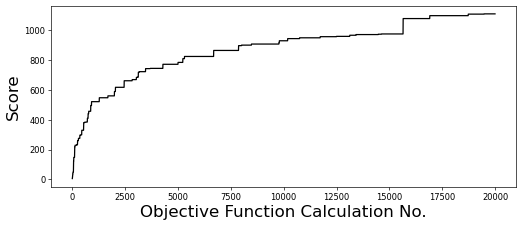

In [3]:

plt.figure(figsize=(10,4),dpi=60)
plt.plot(scores,color="black")
plt.ylabel("Score",fontsize=20)
plt.xlabel("Objective Function Calculation No.",fontsize=20)
plt.show()

#### **Interference pattern to estimates performance more accurately:**

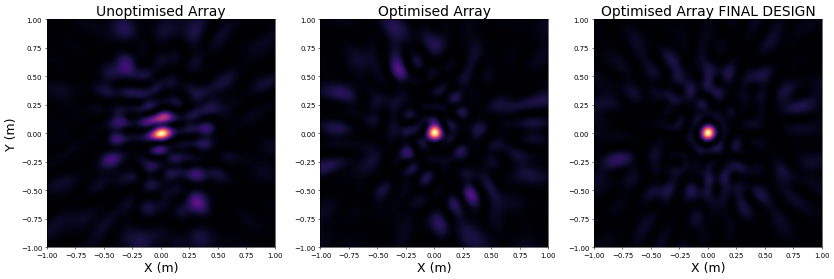

In [9]:
resolution = 300
PAA.width = 2
PAA.Z_depth = 1
interference_pattern1 = PAA.create_image("test_array_random.csv", resolution)
interference_pattern2 = PAA.create_image("test_array.csv", resolution)
interference_pattern3 = PAA.create_image("Designs/20Ant.csv", resolution) # ANother example array. You can remove this array or use your own to compare to

# Create a figure for the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 10), dpi=50)

# First subplot for the unoptimised array
axs[0].set_title("Unoptimised Array", fontsize=20)
axs[0].imshow(interference_pattern1, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[0].set_xlabel('X (m)', fontsize=18)
axs[0].set_ylabel('Y (m)', fontsize=18)

# Second subplot for the optimised array
axs[1].set_title("Optimised Array", fontsize=20)
axs[1].imshow(interference_pattern2, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[1].set_xlabel('X (m)', fontsize=18)

# Third subplot for the another array
axs[2].set_title("Optimised Array FINAL DESIGN", fontsize=20)
axs[2].imshow(interference_pattern3, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[2].set_xlabel('X (m)', fontsize=18)

# Display the figure with subplots
plt.show()


#### **Image Reconstruction:**

90000it [00:07, 11910.05it/s]
90000it [00:07, 11862.99it/s]
90000it [00:07, 11692.86it/s]


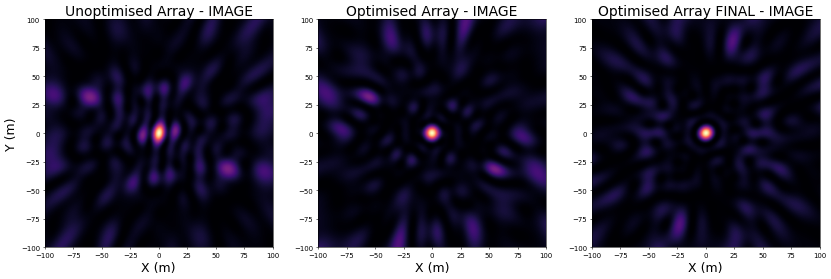

In [10]:
PAA.Z_depth = 100 #m
PAA.width = 200 # m
PAA.freq = 20e9
PAA.res = 300

Image1 = PAA.capture_virtual_image(arrays[0])  # Initial array
Image2 = PAA.capture_virtual_image(arrays[-1]) # Final array
array_20Ant = PAA.load_array("Designs/20Ant.csv")
Image3 = PAA.capture_virtual_image(array_20Ant)

# Create a figure for the subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 10), dpi=50)

# First subplot for the unoptimised array
axs[0].set_title("Unoptimised Array - IMAGE", fontsize=20)
axs[0].imshow(Image1, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[0].set_xlabel('X (m)', fontsize=18)
axs[0].set_ylabel('Y (m)', fontsize=18)

# Second subplot for the optimised array
axs[1].set_title("Optimised Array - IMAGE", fontsize=20)
axs[1].imshow(Image2, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[1].set_xlabel('X (m)', fontsize=18)

# Third subplot for the another array
axs[2].set_title("Optimised Array FINAL - IMAGE", fontsize=20)
axs[2].imshow(Image3, extent = [-PAA.width/2, PAA.width/2, -PAA.width/2, PAA.width/2],cmap="magma")
axs[2].set_xlabel('X (m)', fontsize=18)


# Display the figure with subplots
plt.show()

#### We can compare the objective functions on a sample of the arrays:

In [ ]:
test_objective_function1 = PAA.score_array_angles_and_separations
test_objective_function2 = PAA.score_directivity

# Lets take a random sample of the arrays:
num_samples = 100
# calculate step size
step_size = len(arrays) / num_samples

# get 100 evenly spaced indices
indices = np.linspace(0, len(arrays) - 1, num_samples, dtype=int)

# use these indices to sample from your list
sample_arrays = [arrays[i] for i in indices]

scores_objective_function1 = [test_objective_function1(array_sampled) for array_sampled in sample_arrays]
scores_objective_function2 = [test_objective_function2(array_sampled) for array_sampled in sample_arrays]

In [ ]:
plt.figure(figsize=(10,4),dpi=80)
plt.title("Is there a correlation between two objective functions?",fontsize=15)
plt.scatter(scores_objective_function1,scores_objective_function2,marker="x",color="black",alpha=1)
plt.xlabel(f"Func: {test_objective_function1.__name__}",fontsize=17)
plt.ylabel(f"Func: {test_objective_function2.__name__}",fontsize=17)
plt.show()

#### **View the Design:**

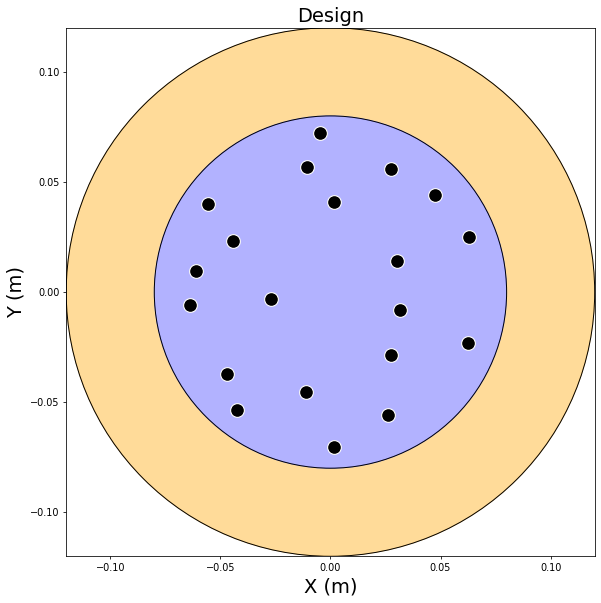

In [11]:
# 1. Choose your array:
#array_to_view = arrays[-1]
array_to_view = PAA.load_array("Designs/20Ant.csv")
PAA.plot_array_design_only_antennas(array_to_view,70)
